# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [24]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=analytic', 
                                                      'case=0_sanity_check', 
                                                      'case/data=CIFAR10'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case sanity_check with server type honest_but_curious.
Attack settings are:
type: analytic
attack_type: analytic



{'device': device(type='cuda'), 'dtype': torch.float32}

These configurations run the sanity check which is a simple linear model. Recovering information from the linear model is trivial, especially if the user data has unique class labels.

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [26]:
cfg.case.user.data_idx = 0
cfg.case.user.num_data_points = 64

### Instantiate all parties

In [27]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Files already downloaded and verified
Model architecture <class 'torch.nn.modules.container.Sequential'> loaded with 30,730 parameters and 0 buffers.
Overall this is a data ratio of       0:1 for target shape [64, 3, 32, 32] given that num_queries=1.


In [28]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of local updates: 1
            number of data points: 64
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: Sequential
            loss function: CrossEntropyLoss()

            Data:
            Dataset: CIFAR10
            data_idx: 0
        


### Simulate an attacked FL protocol

In [29]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# True user data is returned only for analysis

['cat', 'airplane', 'horse', 'frog', 'deer', 'truck', 'horse', 'bird', 'ship', 'airplane', 'deer', 'deer', 'ship', 'deer', 'frog', 'ship', 'bird', 'truck', 'airplane', 'dog', 'dog', 'horse', 'horse', 'dog', 'automobile', 'dog', 'ship', 'bird', 'truck', 'automobile', 'frog', 'ship', 'cat', 'automobile', 'bird', 'truck', 'truck', 'deer', 'frog', 'automobile', 'truck', 'horse', 'deer', 'bird', 'automobile', 'bird', 'dog', 'cat', 'ship', 'automobile', 'deer', 'dog', 'dog', 'truck', 'automobile', 'dog', 'airplane', 'frog', 'deer', 'frog', 'ship', 'frog', 'horse', 'bird']


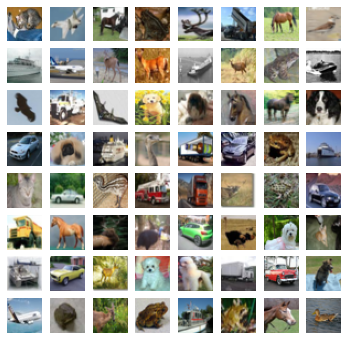

In [30]:
user.plot(true_user_data)

### Reconstruct user data:

In [32]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, server.secrets, 
                                                      shared_data, dryrun=cfg.dryrun)

# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, 
                                    true_user_data, server_payload, server.model, setup)

KeyError: 'buffers'

['cat', 'airplane', 'horse', 'frog', 'deer', 'truck', 'horse', 'bird', 'ship', 'airplane', 'deer', 'deer', 'ship', 'deer', 'frog', 'ship', 'bird', 'truck', 'airplane', 'dog', 'dog', 'horse', 'horse', 'dog', 'automobile', 'dog', 'ship', 'bird', 'truck', 'automobile', 'frog', 'ship', 'cat', 'automobile', 'bird', 'truck', 'truck', 'deer', 'frog', 'automobile', 'truck', 'horse', 'deer', 'bird', 'automobile', 'bird', 'dog', 'cat', 'ship', 'automobile', 'deer', 'dog', 'dog', 'truck', 'automobile', 'dog', 'airplane', 'frog', 'deer', 'frog', 'ship', 'frog', 'horse', 'bird']


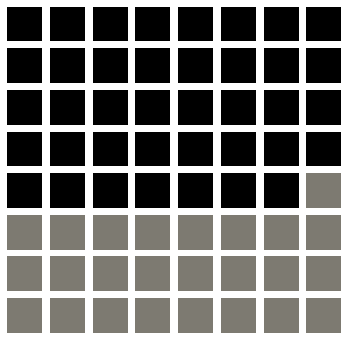

In [33]:
user.plot(reconstructed_user_data)

# Visualize differences

The problem is not well-conditioned, and even in this setting, information is lost due to floating-point precision after the division of weight and bias gradients and the reconstruction is only near-perfect.#

In [34]:
diff_data = dict(data=(reconstructed_user_data['data'] - true_user_data['data']).abs().sqrt(),
                 labels=shared_data['labels'])

['cat', 'airplane', 'horse', 'frog', 'deer', 'truck', 'horse', 'bird', 'ship', 'airplane', 'deer', 'deer', 'ship', 'deer', 'frog', 'ship', 'bird', 'truck', 'airplane', 'dog', 'dog', 'horse', 'horse', 'dog', 'automobile', 'dog', 'ship', 'bird', 'truck', 'automobile', 'frog', 'ship', 'cat', 'automobile', 'bird', 'truck', 'truck', 'deer', 'frog', 'automobile', 'truck', 'horse', 'deer', 'bird', 'automobile', 'bird', 'dog', 'cat', 'ship', 'automobile', 'deer', 'dog', 'dog', 'truck', 'automobile', 'dog', 'airplane', 'frog', 'deer', 'frog', 'ship', 'frog', 'horse', 'bird']


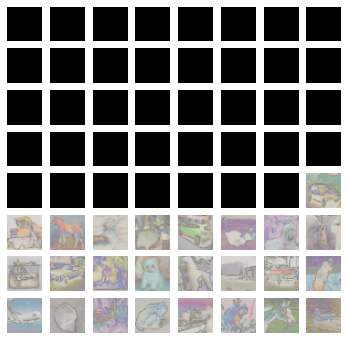

In [35]:
user.plot(diff_data)

### Sept 14: CIFAR? 

In [1]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=analytic', 
                                                      'case=0_sanity_check', 
                                                      'case/data=CIFAR10'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

NameError: name 'hydra' is not defined

In [39]:
# cfg.dryrun = False
# cfg.attack.optim.step_size=1.0
cfg.case.user.data_idx = 0
# cfg.case.model = 'resnet50'
#cfg.case.server.model_state='moco'
cfg.case.user.num_data_points = 64

In [40]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Files already downloaded and verified
Model architecture <class 'torch.nn.modules.container.Sequential'> loaded with 30,730 parameters and 0 buffers.
Overall this is a data ratio of       0:1 for target shape [64, 3, 32, 32] given that num_queries=1.


In [41]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of local updates: 1
            number of data points: 64
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: Sequential
            loss function: CrossEntropyLoss()

            Data:
            Dataset: CIFAR10
            data_idx: 0
        


In [42]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# True user data is returned only for analysis

['cat', 'airplane', 'horse', 'frog', 'deer', 'truck', 'horse', 'bird', 'ship', 'airplane', 'deer', 'deer', 'ship', 'deer', 'frog', 'ship', 'bird', 'truck', 'airplane', 'dog', 'dog', 'horse', 'horse', 'dog', 'automobile', 'dog', 'ship', 'bird', 'truck', 'automobile', 'frog', 'ship', 'cat', 'automobile', 'bird', 'truck', 'truck', 'deer', 'frog', 'automobile', 'truck', 'horse', 'deer', 'bird', 'automobile', 'bird', 'dog', 'cat', 'ship', 'automobile', 'deer', 'dog', 'dog', 'truck', 'automobile', 'dog', 'airplane', 'frog', 'deer', 'frog', 'ship', 'frog', 'horse', 'bird']


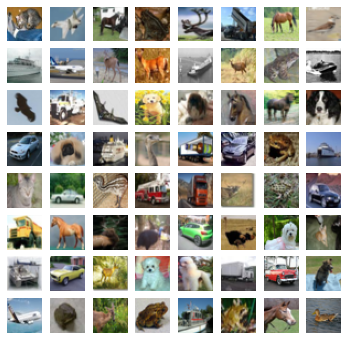

In [43]:
user.plot(true_user_data)

In [44]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, dryrun=cfg.dryrun)

# How good is the reconstruction?
#metrics = breaching.analysis.report(reconstructed_user_data, 
#                                    true_user_data, server_payload, server.model, setup)

['cat', 'airplane', 'horse', 'frog', 'deer', 'truck', 'horse', 'bird', 'ship', 'airplane', 'deer', 'deer', 'ship', 'deer', 'frog', 'ship', 'bird', 'truck', 'airplane', 'dog', 'dog', 'horse', 'horse', 'dog', 'automobile', 'dog', 'ship', 'bird', 'truck', 'automobile', 'frog', 'ship', 'cat', 'automobile', 'bird', 'truck', 'truck', 'deer', 'frog', 'automobile', 'truck', 'horse', 'deer', 'bird', 'automobile', 'bird', 'dog', 'cat', 'ship', 'automobile', 'deer', 'dog', 'dog', 'truck', 'automobile', 'dog', 'airplane', 'frog', 'deer', 'frog', 'ship', 'frog', 'horse', 'bird']


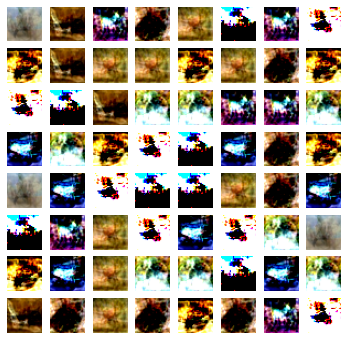

In [45]:
user.plot(reconstructed_user_data)

## CIFAR but with Imprint module?

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=imprint', 'case/server=malicious-model',
                                                      'case=0_sanity_check', 
                                                      'case/data=CIFAR10'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case sanity_check with server type malicious_model.
Attack settings are:
type: analytic
attack_type: imprint-readout



{'device': device(type='cuda'), 'dtype': torch.float32}

In [17]:
# cfg.dryrun = False
# cfg.attack.optim.step_size=1.0
cfg.case.user.data_idx = 0
cfg.case.server.model_modification.ImprintBlock.num_bins = 300
cfg.case.user.num_data_points = 64

In [18]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Files already downloaded and verified
Files already downloaded and verified
Model architecture <class 'torch.nn.modules.container.Sequential'> loaded with 1,877,302 parameters and 0 buffers.
Overall this is a data ratio of      10:1 for target shape [64, 3, 32, 32] given that num_queries=1.


In [19]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of data points: 64
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: Sequential
            loss function: CrossEntropyLoss()

            Data:
            Dataset: CIFAR10
            data_idx: 0
        


In [21]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# True user data is returned only for analysis

['cat', 'airplane', 'horse', 'frog', 'deer', 'truck', 'horse', 'bird', 'ship', 'airplane', 'deer', 'deer', 'ship', 'deer', 'frog', 'ship', 'bird', 'truck', 'airplane', 'dog', 'dog', 'horse', 'horse', 'dog', 'automobile', 'dog', 'ship', 'bird', 'truck', 'automobile', 'frog', 'ship', 'cat', 'automobile', 'bird', 'truck', 'truck', 'deer', 'frog', 'automobile', 'truck', 'horse', 'deer', 'bird', 'automobile', 'bird', 'dog', 'cat', 'ship', 'automobile', 'deer', 'dog', 'dog', 'truck', 'automobile', 'dog', 'airplane', 'frog', 'deer', 'frog', 'ship', 'frog', 'horse', 'bird']


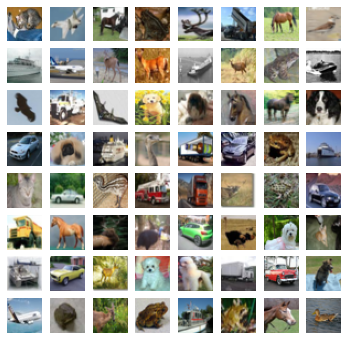

In [22]:
user.plot(true_user_data)

In [23]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, server.secrets, 
                                                      dryrun=cfg.dryrun)

# How good is the reconstruction?
#metrics = breaching.analysis.report(reconstructed_user_data, 
#                                    true_user_data, server_payload, server.model, setup)

['cat', 'airplane', 'horse', 'frog', 'deer', 'truck', 'horse', 'bird', 'ship', 'airplane', 'deer', 'deer', 'ship', 'deer', 'frog', 'ship', 'bird', 'truck', 'airplane', 'dog', 'dog', 'horse', 'horse', 'dog', 'automobile', 'dog', 'ship', 'bird', 'truck', 'automobile', 'frog', 'ship', 'cat', 'automobile', 'bird', 'truck', 'truck', 'deer', 'frog', 'automobile', 'truck', 'horse', 'deer', 'bird', 'automobile', 'bird', 'dog', 'cat', 'ship', 'automobile', 'deer', 'dog', 'dog', 'truck', 'automobile', 'dog', 'airplane', 'frog', 'deer', 'frog', 'ship', 'frog', 'horse', 'bird']


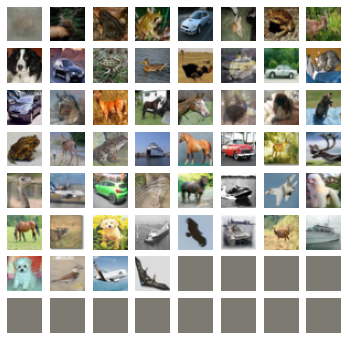

In [24]:
user.plot(reconstructed_user_data)

In [25]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /cmlscratch/lfowl/miniconda3/envs/decision_bound/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
METRICS: | MSE: 0.0204 | PSNR: 85.49 | FMSE: 3.4861e+02 | LPIPS: 0.12| R-PSNR: 85.49 | IIP-pixel: 4.69%


In [26]:
ordered_user_data = dict(data=reconstructed_user_data['data'][metrics['order']], 
                         labels=reconstructed_user_data['labels'][metrics['order']])

['ship', 'deer', 'ship', 'horse', 'bird', 'dog', 'automobile', 'frog', 'dog', 'truck', 'airplane', 'dog', 'frog', 'deer', 'cat', 'horse', 'horse', 'dog', 'dog', 'cat', 'ship', 'airplane', 'automobile', 'bird', 'deer', 'ship', 'frog', 'frog', 'dog', 'bird', 'truck', 'ship', 'deer', 'frog', 'deer', 'airplane', 'horse', 'bird', 'deer', 'ship', 'dog', 'bird', 'airplane', 'automobile', 'truck', 'ship', 'horse', 'automobile', 'automobile', 'deer', 'automobile', 'truck', 'bird', 'truck', 'cat', 'bird', 'automobile', 'dog', 'frog', 'truck', 'truck', 'frog', 'horse', 'deer']


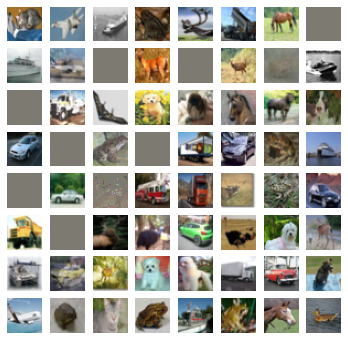

In [51]:
user.plot(ordered_user_data)

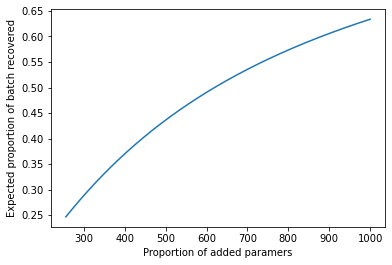

In [31]:
import matplotlib.pyplot as plt
params = 3072 
total = 11173962
param_count = []
proportion = []


for i in range(256, 1001):
    #param_count.append(i * params / total)
    param_count.append(i)
    proportion.append(breaching.analysis.expected_amount(i, 256) / 256)
    
plt.plot(param_count, proportion)
plt.xlabel('Proportion of added paramers')
plt.ylabel('Expected proportion of batch recovered')
plt.show()

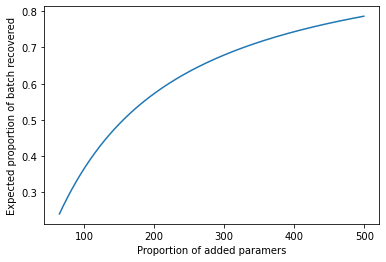

"\n\n\n# Here we produce Figure 2b\nparam_count = []\nproportion = []\nn=4096 #number of datapoints\nfor i in range(600, 12000, 100): # Some range including n. Might need smaller step than 100 for smaller n\n    param_count.append(1/i)\n    proportion.append(one_shot_guarantee(i, n))\n\nprint(proportion[np.argmax(np.array(proportion))])\nprint(param_count[np.argmax(np.array(proportion))])\nplt.plot(param_count, proportion)\nplt.xlabel('Mass captured in one-shot bin')\nplt.ylabel('Probability of one-shot success')\nplt.show()\n"

In [46]:
from math import comb as nCr
import numpy as np
import matplotlib.pyplot as plt

def expected_amount(k, n):
    """
    k number of bins, n batch size
    """
    total_num = nCr(k + n - 1, k - 1)  # Total number of configs
    weight = 0
    for i in range(1, n - 1):
        temp = i * nCr(k, i)
        temp2 = 0
        for j in range(1, (n - i) // 2 + 1):
            temp2 += nCr(k - i, j) * nCr(n - i - j - 1, j - 1)
        weight += temp * temp2
    adjustment1 = n * nCr(k, n)  # First term in r(n,k)
    weight += adjustment1
    return weight / total_num - n / k  # Second adjustment term in r(n,k)

def one_shot_guarantee(k, n):
    """
    k number of bins, n batch size
    """
    total_num = nCr(k + n - 1, k - 1)  # Total number of configs
    weight = 0
    weight += nCr(n+k-3, k-2)
    return weight / total_num  


# Here we produce Figure 2a
params = 3*224*224
total = 25600000
param_count = []
proportion = []
for i in range(65, 500):
    #param_count.append(i * params / total)
    param_count.append(i)
    proportion.append(breaching.analysis.expected_amount(i, 64) / 64)
    
plt.plot(param_count, proportion)
plt.xlabel('Proportion of added paramers')
plt.ylabel('Expected proportion of batch recovered')
plt.show()
'''


# Here we produce Figure 2b
param_count = []
proportion = []
n=4096 #number of datapoints
for i in range(600, 12000, 100): # Some range including n. Might need smaller step than 100 for smaller n
    param_count.append(1/i)
    proportion.append(one_shot_guarantee(i, n))

print(proportion[np.argmax(np.array(proportion))])
print(param_count[np.argmax(np.array(proportion))])
plt.plot(param_count, proportion)
plt.xlabel('Mass captured in one-shot bin')
plt.ylabel('Probability of one-shot success')
plt.show()
'''

# OneShot ImageNet

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=imprint', 'case/server=malicious-model',
                                                      'case=0_sanity_check'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case sanity_check with server type malicious_model.
Attack settings are:
type: analytic
attack_type: imprint-readout



{'device': device(type='cuda'), 'dtype': torch.float32}

In [3]:
# cfg.dryrun = False
# cfg.attack.optim.step_size=1.0
cfg.case.server.model_modification = {'OneShotBlock': {'alpha': 0.375, 'num_bins': 8192*2}}
cfg.case.user.num_data_points = 8192*2
print(cfg.case.server.model_modification)
cfg.case.data.path= "~/data"

cfg.case.user.data_idx = 1
#cfg.case.server.model_modification.ImprintBlock.num_bins = 8192

user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

{'OneShotBlock': {'alpha': 0.375, 'num_bins': 16384}}
Model architecture <class 'torch.nn.modules.container.Sequential'> loaded with 150,980,585 parameters and 0 buffers.
Overall this is a data ratio of       0:1 for target shape [16384, 3, 224, 224] given that num_queries=1.


In [4]:
img = torch.load('reconstructed_data.pth')

In [11]:
distances = []
labels = []
for batch_idx, (inputs, targets) in enumerate(user.dataloader):
    inputs = inputs.cuda()
    distances.append(torch.norm((inputs - img.cuda()).view(inputs.shape[0], -1), dim=-1).cpu())
    labels.append(targets)



In [13]:
torch.cat(labels)[torch.cat(distances).argmin()]
torch.cat(distances).argmin()

tensor(32734)

In [6]:
img

tensor([[[ 0.5878,  0.2282,  0.1426,  ..., -0.0629,  0.0741,  0.0056],
         [ 0.2453,  0.4166,  0.2111,  ..., -0.0801,  0.0227, -0.0116],
         [-0.2856,  0.2624,  0.5193,  ..., -0.0116,  0.0912,  0.0398],
         ...,
         [-1.0904, -1.1075, -1.1075,  ..., -0.7479, -0.7479, -0.7650],
         [-0.9534, -0.9534, -1.0733,  ..., -0.6623, -0.6452, -0.6965],
         [-0.8507, -1.0219, -1.0562,  ..., -0.5596, -0.6281, -0.7479]],

        [[ 0.6604,  0.2927,  0.2752,  ...,  0.0476,  0.1877,  0.1352],
         [ 0.3102,  0.4678,  0.3452,  ...,  0.0301,  0.1352,  0.1001],
         [-0.2150,  0.3627,  0.6429,  ...,  0.1001,  0.2227,  0.1702],
         ...,
         [-1.0028, -1.0728, -1.0553,  ..., -0.7752, -0.7402, -0.7752],
         [-0.9153, -0.9853, -1.0553,  ..., -0.7052, -0.6877, -0.6877],
         [-0.8277, -0.9853, -1.0378,  ..., -0.5826, -0.6702, -0.7227]],

        [[ 0.7576,  0.3916,  0.4439,  ...,  0.2871,  0.4962,  0.4439],
         [ 0.4788,  0.6531,  0.4788,  ...,  0

In [3]:
# cfg.dryrun = False
# cfg.attack.optim.step_size=1.0
cfg.case.server.model_modification = {'OneShotBlock': {'alpha': 0.375, 'num_bins': 8192*2}}
cfg.case.user.num_data_points = 8192*2
print(cfg.case.server.model_modification)
cfg.case.data.path= "~/data"

cfg.case.user.data_idx = 1
#cfg.case.server.model_modification.ImprintBlock.num_bins = 8192

user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, server.secrets, 
                                                      dryrun=cfg.dryrun)



{'OneShotBlock': {'alpha': 0.375, 'num_bins': 16384}}
Model architecture <class 'torch.nn.modules.container.Sequential'> loaded with 150,980,585 parameters and 0 buffers.
Overall this is a data ratio of       0:1 for target shape [16384, 3, 224, 224] given that num_queries=1.


In [6]:
torch.save(reconstructed_user_data['data'][0], 'reconstructed_data.pth')

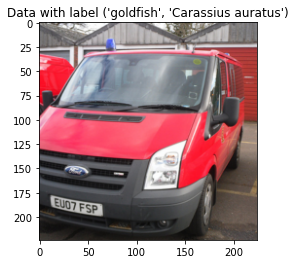

In [4]:
new_data = dict(data=reconstructed_user_data['data'][0].unsqueeze(0), labels=torch.tensor(1))
user.plot(new_data)

In [25]:
recon_data = dict(data=reconstructed_user_data['data'][0].unsqueeze(0), labels=torch.tensor(654))
true_data = dict(data=true_user_data['data'][3583].unsqueeze(0), labels=torch.tensor(654))
print(recon_data['data'].shape, true_data['data'].shape)

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


In [23]:
metrics = breaching.analysis.report(recon_data, true_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /cmlscratch/lfowl/miniconda3/envs/decision_bound/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
METRICS: | MSE: 0.0000 | PSNR: 161.36 | FMSE: 0.0000e+00 | LPIPS: 0.00| R-PSNR: 161.36 | IIP-pixel: 100.00%


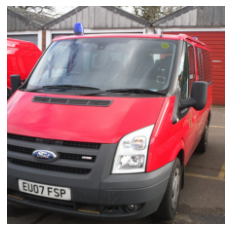

In [40]:
user.plot(recon_data)

In [ ]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /cmlscratch/lfowl/miniconda3/envs/decision_bound/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


/cmlscratch/lfowl/miniconda3/envs/decision_bound/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
from PIL import Image 
import torchvision.transforms as transforms 

#tensor_to_pil = transforms.ToPILImage()(img.squeeze_(0))
print(true_user_data['data'].shape)
imgs = []
for i in range(true_user_data['data'].shape[0]): 
    img = true_user_data['data'][i]
    label = true_user_data['labels'][i]
    #for i in range(len(user.dataloader.dataset)):
    #img, label = user.dataloader.dataset[i]
    if label == 654:
        imgs.append((img, i))
        

torch.Size([16384, 3, 224, 224])


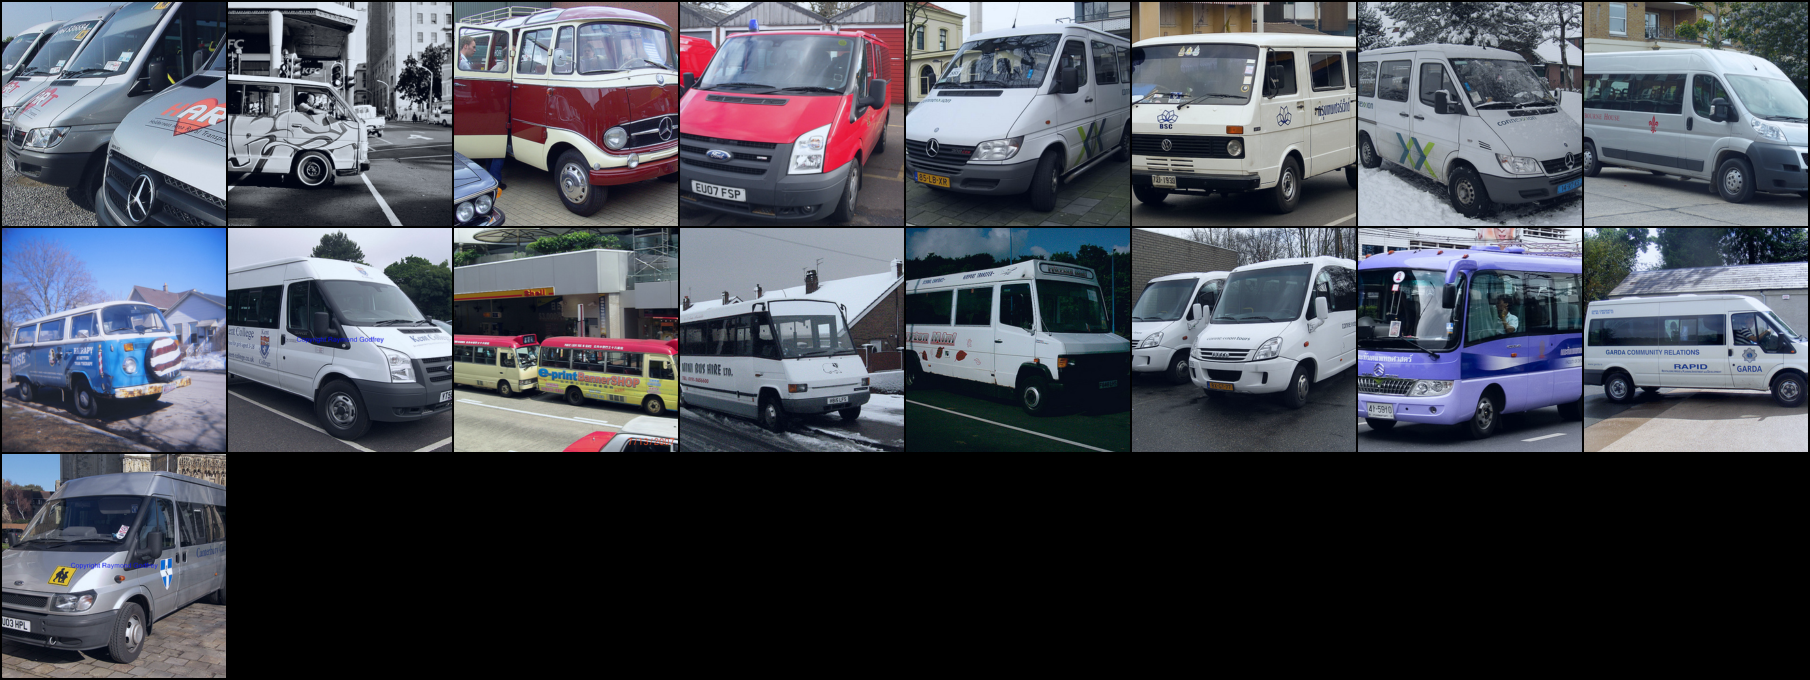

3583

In [14]:
toPIL = transforms.ToPILImage()
import torchvision
torchvision.utils.save_image([imgs[i][0] for i in range(len(imgs))], 'ambulance.png', normalize=True)
#img = [toPIL(imgs[i][0]) for i in range(len(imgs))]
img = Image.open('./ambulance.png')
display(img)
imgs[3][1]

[('Afghan hound', 'Afghan'), ('Afghan hound', 'Afghan')]
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /cmlscratch/lfowl/miniconda3/envs/decision_bound/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
METRICS: | MSE: 0.0000 | PSNR: 157.75 | FMSE: 1.9738e-14 | LPIPS: 0.00| R-PSNR: 157.75 | IIP-pixel: 100.00%


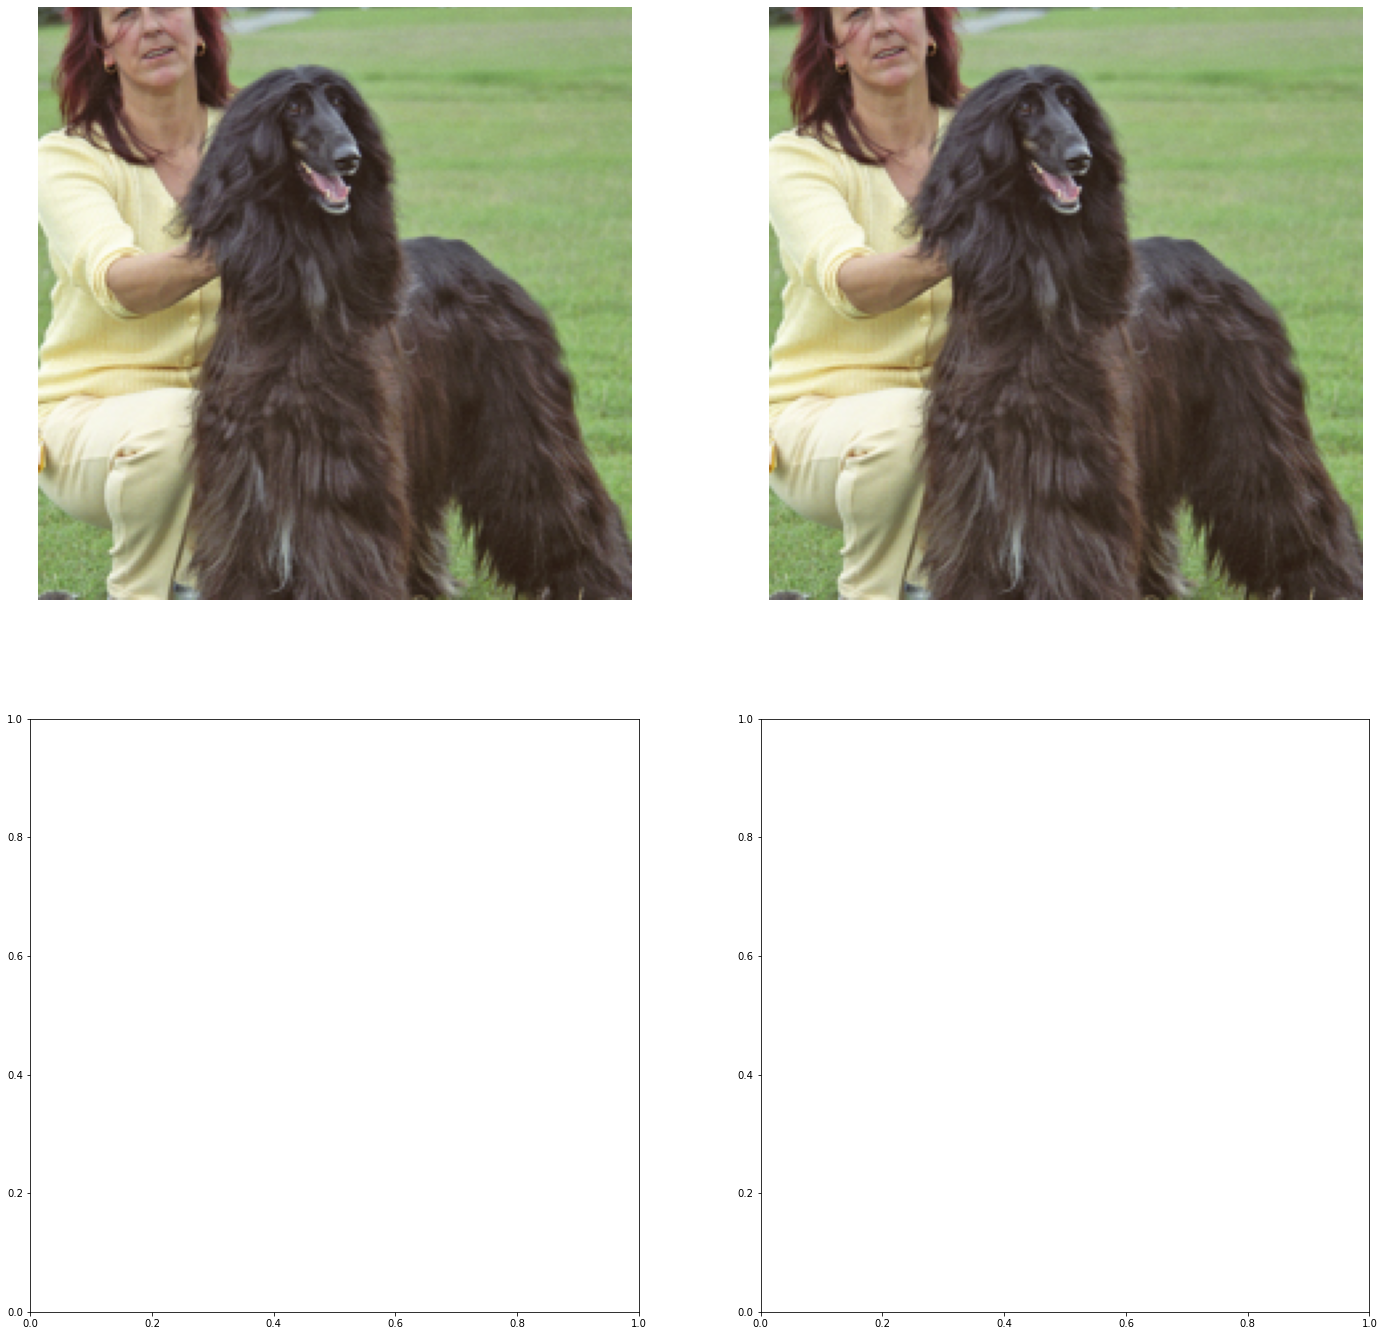

In [39]:
'''
ordered_user_data = dict(data=reconstructed_user_data['data'][metrics['order']], 
                         labels=reconstructed_user_data['labels'][metrics['order']])
'''
true_img = true_user_data['data'][int(metrics['one_shot_idx'].item())]
one_shot_img = reconstructed_user_data['data'][int(metrics['one_shot_idx'].item())]
true_label = true_user_data['labels'][int(metrics['one_shot_idx'].item())]
data = torch.stack([true_img, one_shot_img])
labels = torch.stack([true_label, true_label])
#data=torch.stack([true_user_data['data'][int(metrics['one_shot_idx'].item())], reconstructed_user_data['data'][int(metrics['one_shot_idx'].item())]])
#labels=torch.stack([true_user_data['labels'][int(metrics['one_shot_idx'].item())], true_user_data['labels'][int(metrics['one_shot_idx'].item())]])
user.plot(dict(data=data, labels=labels))
true_img = true_img.unsqueeze(0)
one_shot_img = one_shot_img.unsqueeze(0)
metrics = breaching.analysis.report(dict(data=one_shot_img, labels=labels), dict(data=true_img, labels=labels), 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False)

In [30]:
user_data['labels']

NameError: name 'user_data' is not defined

In [1]:

img = torch.load('reconstructed_data.pth')

NameError: name 'torch' is not defined